# **Insurance Funds Clustering - Unsupervised Learning**  
## **Team Members**:  
- **Itamar Melnik** (ID: 207312307)  
- **Tomer Sabag** (ID: 318814977)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ppscore as pps
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import math
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

## **Load and Preview the Data**

In [2]:
df = pd.read_csv('file.csv', encoding= 'windows-1255' )

In [3]:
df.head()

,FUND_ID,FUND_NAME,PARENT_COMPANY_ID,PARENT_COMPANY_NAME,FUND_CLASSIFICATION,REPORT_PERIOD,TOTAL_ASSETS,AVG_ANNUAL_MANAGEMENT_FEE,AVG_DEPOSIT_FEE,MONTHLY_YIELD,...,AVG_ANNUAL_YIELD_TRAILING_5YRS,STANDARD_DEVIATION,ALPHA,SHARPE_RATIO,LIQUID_ASSETS_PERCENT,STOCK_MARKET_EXPOSURE,FOREIGN_EXPOSURE,FOREIGN_CURRENCY_EXPOSURE,PARENT_COMPANY_LEGAL_ID,CURRENT_DATE
0,1,"איי. די. איי. חברה לביטוח בע""מ מסלול אג""ח ממשלות",60,"ישיר -איי. די. איי. חברה לביטוח בע""מ",פוליסות שהונפקו החל משנת 2004,202401,88.87,1.01,NaN,0.27,...,2.06,1.87,0.36,0.24,89.9,1.37,7.46,11.20,513910703,12/29/2024 12:00:00 AM
1,1,"איי. די. איי. חברה לביטוח בע""מ מסלול אג""ח ממשלות",60,"ישיר -איי. די. איי. חברה לביטוח בע""מ",פוליסות שהונפקו החל משנת 2004,202402,88.05,1.01,NaN,0.15,...,2.01,1.87,0.24,0.18,90.0,1.62,7.41,11.18,513910703,12/29/2024 12:00:00 AM
2,1,"איי. די. איי. חברה לביטוח בע""מ מסלול אג""ח ממשלות",60,"ישיר -איי. די. איי. חברה לביטוח בע""מ",פוליסות שהונפקו החל משנת 2004,202403,87.89,1.01,NaN,0.66,...,2.07,1.91,0.36,0.21,89.6,1.70,7.90,11.80,513910703,12/29/2024 12:00:00 AM
3,1,"איי. די. איי. חברה לביטוח בע""מ מסלול אג""ח ממשלות",60,"ישיר -איי. די. איי. חברה לביטוח בע""מ",פוליסות שהונפקו החל משנת 2004,202404,86.32,1.01,NaN,-0.36,...,1.94,1.91,0.24,0.06,89.5,1.64,7.76,11.36,513910703,12/29/2024 12:00:00 AM
4,1,"איי. די. איי. חברה לביטוח בע""מ מסלול אג""ח ממשלות",60,"ישיר -איי. די. איי. חברה לביטוח בע""מ",פוליסות שהונפקו החל משנת 2004,202405,85.50,1.01,NaN,0.12,...,1.97,1.91,0.24,0.02,89.4,1.69,7.84,11.41,513910703,12/29/2024 12:00:00 AM


##  Column Removal

* A detailed explanation  in the classification notebook (based on PPS and Spearman corallation matrix)

In [4]:
df = df.drop(columns=['CURRENT_DATE','FUND_NAME','PARENT_COMPANY_ID','PARENT_COMPANY_NAME','FUND_CLASSIFICATION','PARENT_COMPANY_LEGAL_ID','AVG_ANNUAL_YIELD_TRAILING_3YRS','AVG_ANNUAL_YIELD_TRAILING_5YRS','FOREIGN_EXPOSURE'])

## **Visualizing Missing Value Column ON Box Plots**

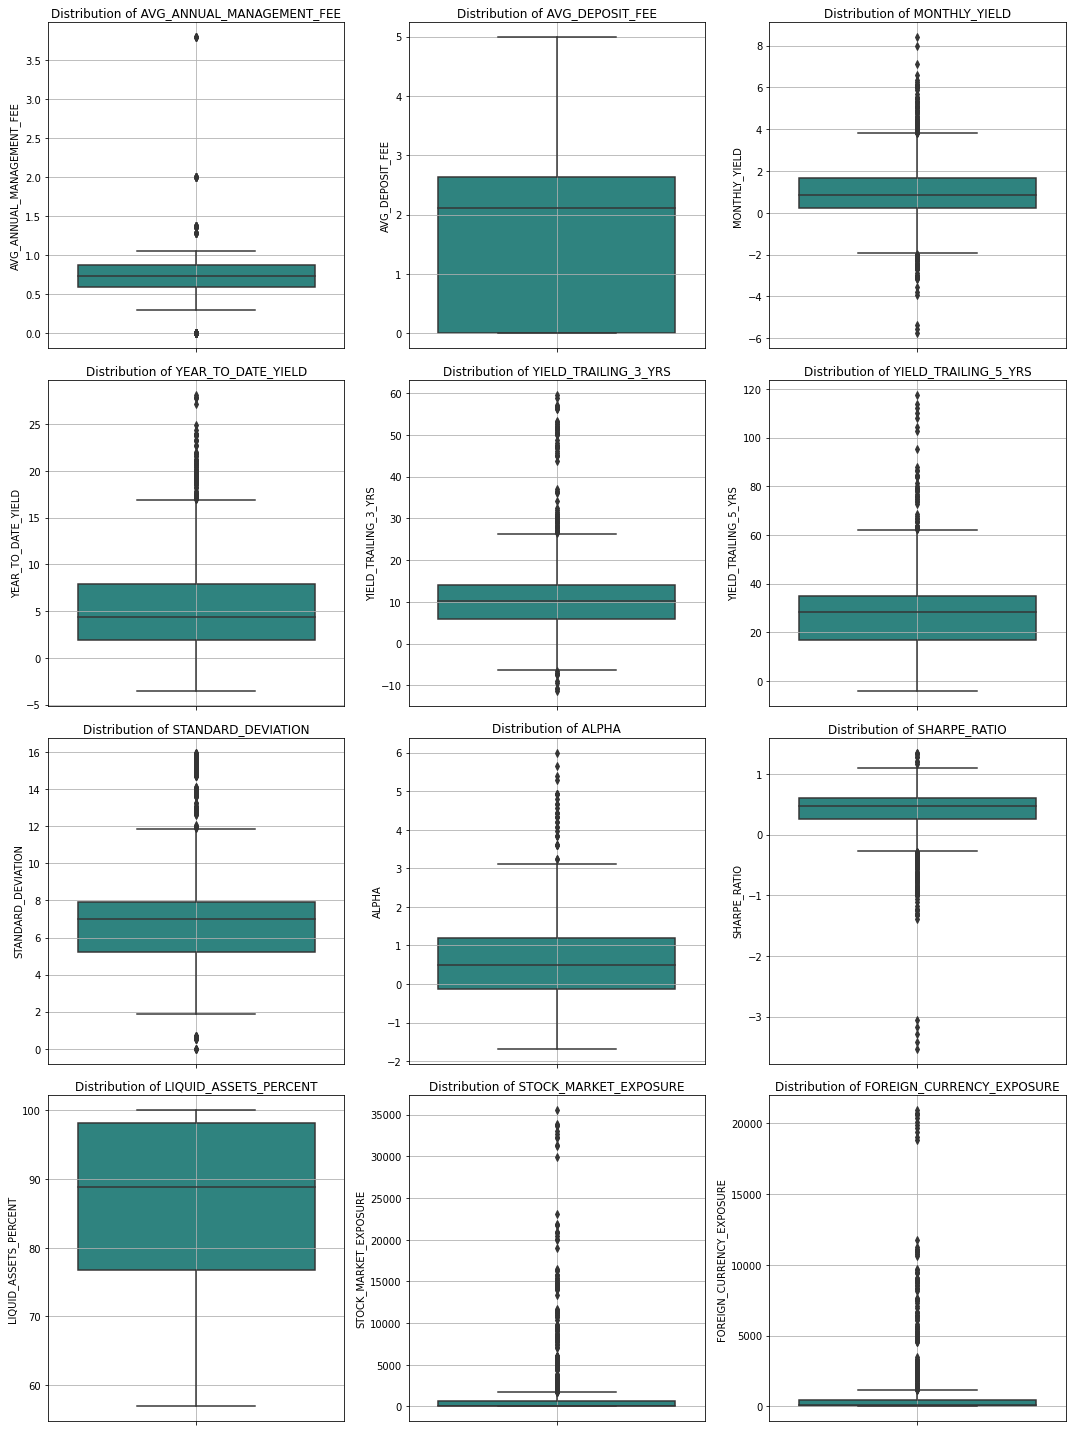

In [5]:
missing_columns = df.columns[df.isnull().any()]

num_cols = 3  
num_rows = math.ceil(len(missing_columns) / num_cols)  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  

for i, column in enumerate(missing_columns):
    sns.boxplot(data=df, y=column, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel('')  
    axes[i].set_ylabel(column)
    axes[i].grid(True)


for i in range(len(missing_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


### **Interpretation of Box Plots**:
- **Observation**: All columns, except `LIQUID_ASSETS_PERCENT`,`AVG_ANNUAL_MANAGEMENT_FEE`, have outliers or asymmetrical distributions. 
- **Imputation Decision**:
  - **Columns with outliers or  asymmetrical  distributions**: Filled with the median for robustness against outliers.
  - **`LIQUID_ASSETS_PERCENT`& `AVG_ANNUAL_MANAGEMENT_FEE` **: Filled with the mean.
  - **Group-Level Imputation**: Before applying global imputation, missing values are first filled using the mean of each company (`FUND_ID`), ensuring that company-specific trends are preserved

In [6]:
for col in df.drop(columns=['FUND_ID']):
    df[col] = df.groupby('FUND_ID')[col].transform(lambda x: x.fillna(x.mean()))


columns_to_fill_median = [
    'TOTAL_ASSETS', 'AVG_DEPOSIT_FEE', 'MONTHLY_YIELD', 
    'YEAR_TO_DATE_YIELD', 'YIELD_TRAILING_3_YRS', 
    'YIELD_TRAILING_5_YRS', 'STANDARD_DEVIATION', 
    'ALPHA', 'SHARPE_RATIO', 'STOCK_MARKET_EXPOSURE','FOREIGN_CURRENCY_EXPOSURE'
]

columns_to_fill_mean = ['AVG_ANNUAL_MANAGEMENT_FEE', 'LIQUID_ASSETS_PERCENT']


df[columns_to_fill_median] = df[columns_to_fill_median].fillna(df[columns_to_fill_median].median())

df[columns_to_fill_mean] = df[columns_to_fill_mean].fillna(df[columns_to_fill_mean].mean())

In [7]:
df = df.drop(columns=['FUND_ID'])

 **Converting `REPORT_PERIOD` Column to Categorical**

In [8]:
df['REPORT_PERIOD'] = df['REPORT_PERIOD'].astype(object)

## **Data Preprocessing**

**Feature Preprocessing**:
   - Numerical features are standardized using `StandardScaler` to ensure they have a mean of 0 and a standard deviation of 1.
   - Categorical features are one-hot encoded using `OneHotEncoder`, dropping the first category to avoid multicollinearity.

In [9]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns
numerical_features = df.select_dtypes(exclude=['object', 'category']).columns


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

X = preprocessor.fit_transform(df)


cat_col_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

all_col_names = list(numerical_features) + list(cat_col_names)

X = pd.DataFrame(X, columns=all_col_names)

## **Cumulative Explained Variance using PCA**

In this step, we use Principal Component Analysis (PCA) to compute the cumulative explained variance. This helps to identify the number of components required to retain most of the variability in the dataset. The plot below visualizes the cumulative variance explained as a function of the number of components:

- **X-axis**: Number of components.
- **Y-axis**: Cumulative explained variance.

This analysis is crucial for dimensionality reduction and determining the optimal number of components to retain.


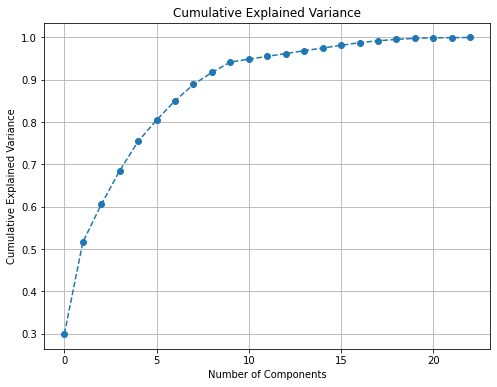

In [10]:
pca = PCA()
pca.fit(X)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# שלב 4: הדמיית השונות המצטברת
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [11]:
pca.explained_variance_ratio_

array([0.29924359, 0.21676654, 0.08933669, 0.07966759, 0.06944125,
       0.05041226, 0.04562255, 0.03844909, 0.02856813, 0.02433861,
       0.00684889, 0.00667697, 0.00665271, 0.00658113, 0.00641817,
       0.00634714, 0.00631463, 0.00444409, 0.00332343, 0.00246855,
       0.00117025, 0.00048986, 0.00041785])

In [12]:
cumulative_variance_ratio

array([0.29924359, 0.51601014, 0.60534683, 0.68501442, 0.75445567,
       0.80486793, 0.85049048, 0.88893957, 0.9175077 , 0.94184631,
       0.9486952 , 0.95537218, 0.96202489, 0.96860602, 0.97502419,
       0.98137133, 0.98768596, 0.99213005, 0.99545348, 0.99792203,
       0.99909229, 0.99958215, 1.        ])

### **Interpretation of Cumulative Explained Variance**

The cumulative explained variance array represents the proportion of variance explained by the principal components. Based on the results, we observe that **7 components** capture approximately **85% of the total variance**, and we have decided to retain these components for dimensionality reduction. 

By reducing the dimensionality, we also aim to eliminate some of the noise in the data, improving the clarity and efficiency of subsequent analyses.



In [13]:
pca1 = PCA(n_components=7)
X_pca = pca1.fit_transform(X)

## **PCA Loadings and Weighted Sum Calculation**

In this step, we calculate the loadings matrix for the Principal Component Analysis (PCA). Each column (`PC1`, `PC2`, etc.) represents the contribution of the original features to a specific principal component. 

Additionally, we compute a **Weighted Sum** for each feature by taking the absolute loadings, weighting them by the explained variance ratio, and summing across all components. This provides an aggregated measure of how strongly each feature contributes to the overall variability captured by the PCA.

In [14]:
loadings = pd.DataFrame(
    pca1.components_.T,  # טרנספוזיציה כך שכל עמודה מייצגת קומפוננטה
    columns=[f"PC{i+1}" for i in range(pca1.n_components_)],  # שמות לוקטורים הראשיים
    index=X.columns  # שמות לתכונות המקוריות
)

loadings['Weighted_Sum'] = (loadings.abs() * pca1.explained_variance_ratio_).sum(axis=1)

In [15]:
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,Weighted_Sum
TOTAL_ASSETS,0.232697,0.494135,0.126140,0.012651,0.059259,-0.017412,-0.069722,0.197195
AVG_ANNUAL_MANAGEMENT_FEE,-0.047085,-0.046960,0.344356,0.705115,0.396938,0.368605,-0.058595,0.160027
AVG_DEPOSIT_FEE,0.053531,0.036490,-0.374332,0.701892,-0.332809,-0.411514,0.051813,0.159508
MONTHLY_YIELD,0.184094,-0.130008,0.349159,0.046844,-0.687940,0.465291,-0.180138,0.197641
YEAR_TO_DATE_YIELD,0.303321,-0.187544,0.295331,0.041106,-0.224973,-0.336673,0.224688,0.203925
YIELD_TRAILING_3_YRS,0.365502,-0.157243,0.141228,-0.040657,-0.038992,-0.147451,0.375530,0.186588
YIELD_TRAILING_5_YRS,0.429446,-0.195390,-0.091904,-0.040954,0.161077,-0.006554,-0.094017,0.198141
STANDARD_DEVIATION,0.348596,-0.233419,-0.025437,-0.033561,0.172541,-0.200625,-0.609474,0.209760
ALPHA,0.341864,-0.040647,-0.304860,0.006202,0.158394,0.408807,0.549499,0.195518
SHARPE_RATIO,0.357432,-0.180935,-0.244256,0.036806,0.142748,0.161221,-0.204834,0.198318


In [16]:
loadings.Weighted_Sum.sort_values()

REPORT_PERIOD_202406         0.002148
REPORT_PERIOD_202407         0.002636
REPORT_PERIOD_202408         0.003502
REPORT_PERIOD_202405         0.004190
REPORT_PERIOD_202402         0.008641
REPORT_PERIOD_202410         0.008804
REPORT_PERIOD_202409         0.011046
REPORT_PERIOD_202403         0.013263
REPORT_PERIOD_202411         0.016670
REPORT_PERIOD_202404         0.024349
AVG_DEPOSIT_FEE              0.159508
AVG_ANNUAL_MANAGEMENT_FEE    0.160027
LIQUID_ASSETS_PERCENT        0.177052
YIELD_TRAILING_3_YRS         0.186588
ALPHA                        0.195518
TOTAL_ASSETS                 0.197195
MONTHLY_YIELD                0.197641
YIELD_TRAILING_5_YRS         0.198141
SHARPE_RATIO                 0.198318
FOREIGN_CURRENCY_EXPOSURE    0.201415
STOCK_MARKET_EXPOSURE        0.203767
YEAR_TO_DATE_YIELD           0.203925
STANDARD_DEVIATION           0.209760
Name: Weighted_Sum, dtype: float64

### **Interpretation of Weighted Sum Results**

The results show that the `REPORT_PERIOD` columns contribute a few variance of the data, with weighted sums significantly lower than other features. Consequently, we removed all `REPORT_PERIOD` columns from the dataset, as they provide minimal explanation for the variability in the data.

In [17]:
columns_to_remove = [col for col in X.columns if col.startswith("REPORT_PERIOD")]
X = X.drop(columns=columns_to_remove)

X_pca = pca1.fit_transform(X)

## **Elbow Method for Optimal Clusters**

This step uses the Elbow Method to identify the optimal number of clusters (`k`) for the K-Means algorithm. By plotting the **inertia** (sum of squared distances) against `k`, the **elbow point** indicates the optimal `k`, balancing cluster compactness and model simplicity.


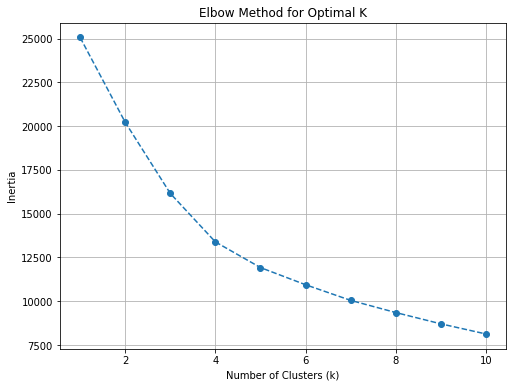

In [18]:
inertia_values = []
k_values = range(1, 11)
# חישוב Inertia עבור כל K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=42)
    kmeans.fit(X_pca)  # ודא ש-X מוכן ומנורמל
    inertia_values.append(kmeans.inertia_)

# יצירת גרף Elbow
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_values, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

### **Elbow Method Interpretation**

As observed in the graph, the **elbow point** occurs at **k = 4**, indicating that 4 clusters provide the perfect balance between compactness and simplicity in the K-Means clustering model.


### **PCA: 2D and 3D Transformations**


In [19]:
pca2c = PCA(n_components=2)
X_pca_2c = pca2c.fit_transform(X)

pca3c = PCA(n_components=3)
X_pca_3c = pca3c.fit_transform(X)

## **K-Means Clustering Visualization (2D and 3D)**

Here, we visualize the clustering results from the K-Means algorithm with **k=4 clusters**. 

- **Left plot**: A 2D scatter plot showing the clusters using the first two PCA.
- **Right plot**: A 3D scatter plot illustrating the clusters using the first three PCA. 

These visualizations provide insights into the cluster separation and structure.

In [20]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters_km = kmeans.fit_predict(X_pca)

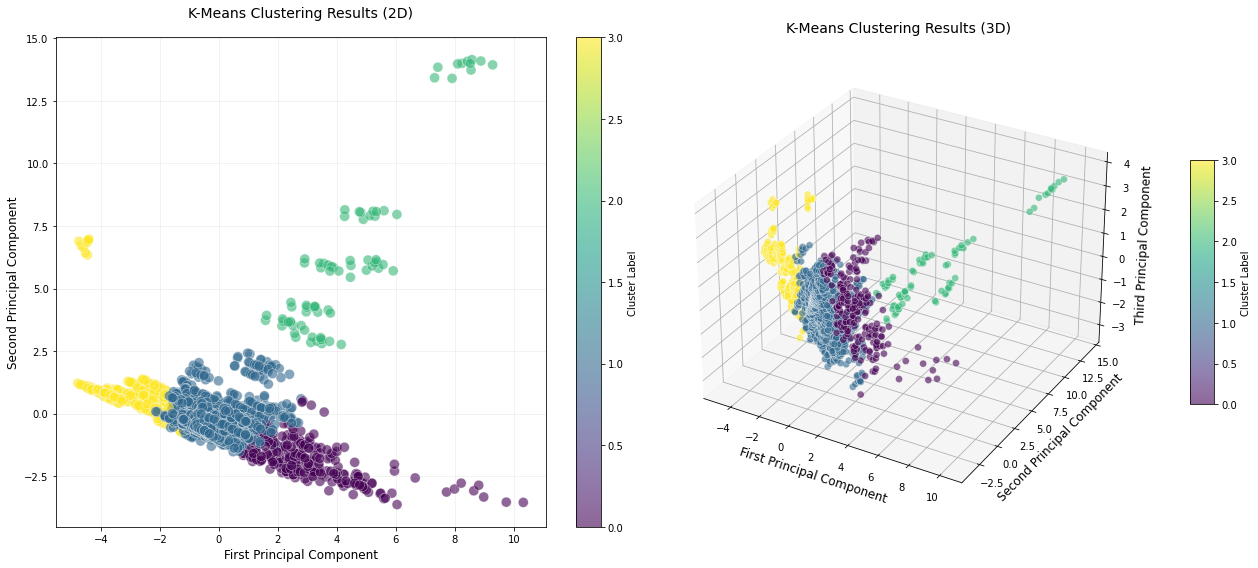

In [21]:

# יצירת גרף עם שני תת-גרפים
fig = plt.figure(figsize=(18, 8))

# גרף דו-ממדי
ax1 = fig.add_subplot(121)
scatter2d = ax1.scatter(
    X_pca_2c[:, 0], X_pca_2c[:, 1],
    c=clusters_km,
    cmap='viridis',
    alpha=0.6,
    s=100,  # גודל נקודות
    edgecolors='white',  # שולי נקודות בלבן
    linewidth=0.5
)
ax1.set_title('K-Means Clustering Results (2D)', pad=20, size=14)
ax1.set_xlabel('First Principal Component', size=12)
ax1.set_ylabel('Second Principal Component', size=12)
ax1.grid(True, alpha=0.2)
fig.colorbar(scatter2d, ax=ax1, label='Cluster Label')

# גרף תלת-ממדי
ax2 = fig.add_subplot(122, projection='3d')
scatter3d = ax2.scatter(
    X_pca_3c[:, 0], X_pca_3c[:, 1], X_pca_3c[:, 2],
    c=clusters_km,
    cmap='viridis',
    alpha=0.6,
    s=50,  # גודל נקודות
    edgecolors='white',  # שולי נקודות בלבן
    linewidth=0.5
)
ax2.set_title('K-Means Clustering Results (3D)', pad=20, size=14)
ax2.set_xlabel('First Principal Component', size=12)
ax2.set_ylabel('Second Principal Component', size=12)
ax2.set_zlabel('Third Principal Component', size=12)
fig.colorbar(scatter3d, ax=ax2, shrink=0.5, aspect=10, pad=0.1, label='Cluster Label')

# עיצוב וסידור
plt.tight_layout()
plt.show()

## Hyperparameter Tuning for DBSCAN

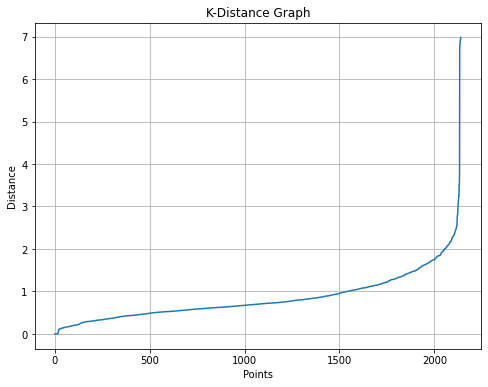

In [22]:
# מציאת המרחקים ל-min_samples הקרובים ביותר
neighbors = NearestNeighbors(n_neighbors=8)  # תאם את min_samples
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

# מיון המרחקים
distances = np.sort(distances[:, -1])  # 4 מתאים ל-n_neighbors - 1
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Points')
plt.ylabel('Distance')
plt.grid()
plt.show()

### **Interpreting the K-Distance Graph**

From the K-Distance graph shown above, the "elbow" is observed within the range of distances between **2 and 3**. This indicates the optimal range for the `eps` parameter in the DBSCAN algorithm. Choosing a value within this range allows the algorithm to capture the density-based clusters effectively while minimizing the noise.


### Find the optimal eps & min_sample values for the DBSCAN model according the highest Silhouette Score results

In [23]:
# טווח פרמטרים לכיוון DBSCAN
eps_values = np.arange(2, 3, 0.1)  # טווח ערכים ל-eps
min_samples_values = range(7,14)     # ערכים עבור min_samples

# משתנים לאחסון התוצאות הטובות ביותר
best_score = -1
best_params = {}
results = []

# חיפוש פרמטרים באמצעות Silhouette Score
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_pca)
        
        # בדיקה אם יש לפחות 2 אשכולות (נדרש ל-Silhouette Score)
        if len(set(clusters)) > 1 and len(set(clusters)) < len(X_pca):
            score = silhouette_score(X_pca, clusters)
            results.append((eps, min_samples, score, len(set(clusters)) - (1 if -1 in clusters else 0)))
            
            # עדכון התוצאה הטובה ביותר
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

# הדפסת הפרמטרים האופטימליים
print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

# הדפסת כל התוצאות
print("\nAll Results:")
for result in results:
    print(f"eps: {result[0]:.2f}, min_samples: {result[1]}, Silhouette Score: {result[2]:.4f}, Clusters: {result[3]}")

Best Silhouette Score: 0.6778
Best Parameters: {'eps': 2.900000000000001, 'min_samples': 12}

All Results:
eps: 2.00, min_samples: 7, Silhouette Score: 0.3103, Clusters: 8
eps: 2.00, min_samples: 8, Silhouette Score: 0.3105, Clusters: 8
eps: 2.00, min_samples: 9, Silhouette Score: 0.3111, Clusters: 8
eps: 2.00, min_samples: 10, Silhouette Score: 0.3122, Clusters: 8
eps: 2.00, min_samples: 11, Silhouette Score: 0.3388, Clusters: 7
eps: 2.00, min_samples: 12, Silhouette Score: 0.5319, Clusters: 1
eps: 2.00, min_samples: 13, Silhouette Score: 0.5288, Clusters: 1
eps: 2.10, min_samples: 7, Silhouette Score: 0.3376, Clusters: 7
eps: 2.10, min_samples: 8, Silhouette Score: 0.3376, Clusters: 7
eps: 2.10, min_samples: 9, Silhouette Score: 0.3105, Clusters: 8
eps: 2.10, min_samples: 10, Silhouette Score: 0.3111, Clusters: 8
eps: 2.10, min_samples: 11, Silhouette Score: 0.3120, Clusters: 8
eps: 2.10, min_samples: 12, Silhouette Score: 0.5534, Clusters: 1
eps: 2.10, min_samples: 13, Silhouette Sc

## **DBSCAN Clustering Visualization (2D and 3D)**

Here, we visualize the clustering results from the DBSCAN algorithm with **eps=2.9 & min_samples=12**. 

- **Left plot**: A 2D scatter plot showing the clusters using the first two PCA.
- **Right plot**: A 3D scatter plot illustrating the clusters using the first three PCA. 

These visualizations provide insights into the cluster separation and structure.

In [24]:
dbscan = DBSCAN(eps=2.9, min_samples=12)
clusters_db = dbscan.fit_predict(X_pca)

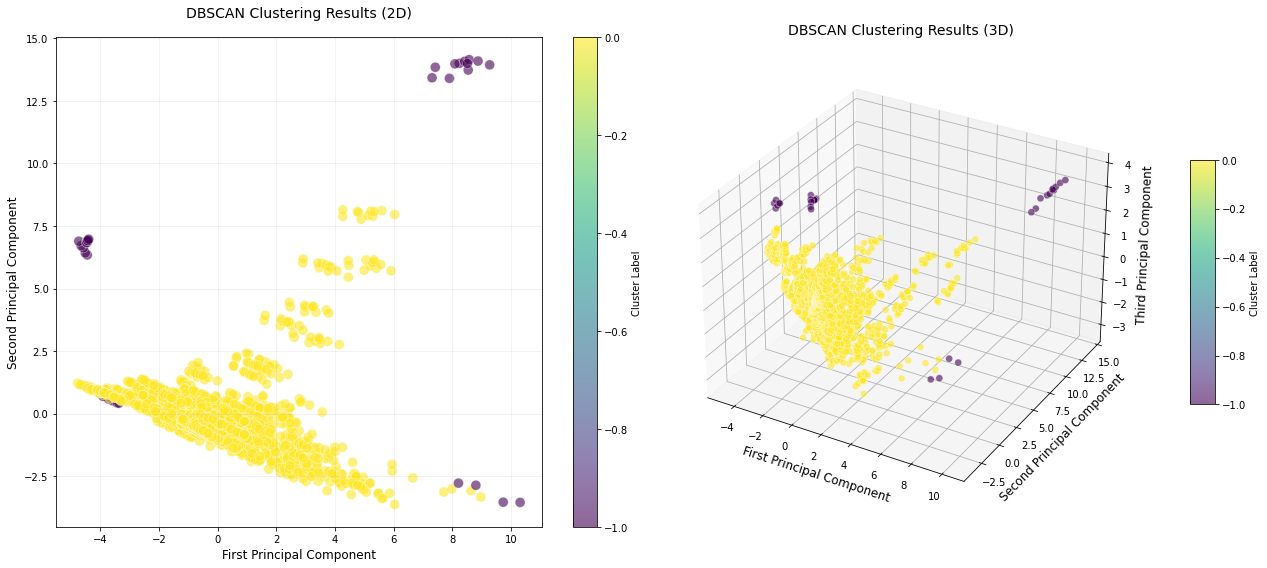

In [25]:

# יצירת גרף עם שני תת-גרפים
fig = plt.figure(figsize=(18, 8))

# גרף דו-ממדי
ax1 = fig.add_subplot(121)
scatter2d = ax1.scatter(
    X_pca_2c[:, 0], X_pca_2c[:, 1],
    c=clusters_db,
    cmap='viridis',
    alpha=0.6,
    s=100,  # גודל נקודות
    edgecolors='white',  # שולי נקודות בלבן
    linewidth=0.5
)
ax1.set_title('DBSCAN Clustering Results (2D)', pad=20, size=14)
ax1.set_xlabel('First Principal Component', size=12)
ax1.set_ylabel('Second Principal Component', size=12)
ax1.grid(True, alpha=0.2)
fig.colorbar(scatter2d, ax=ax1, label='Cluster Label')

# גרף תלת-ממדי
ax2 = fig.add_subplot(122, projection='3d')
scatter3d = ax2.scatter(
    X_pca_3c[:, 0], X_pca_3c[:, 1], X_pca_3c[:, 2],
    c=clusters_db,
    cmap='viridis',
    alpha=0.6,
    s=50,  # גודל נקודות
    edgecolors='white',  # שולי נקודות בלבן
    linewidth=0.5
)
ax2.set_title('DBSCAN Clustering Results (3D)', pad=20, size=14)
ax2.set_xlabel('First Principal Component', size=12)
ax2.set_ylabel('Second Principal Component', size=12)
ax2.set_zlabel('Third Principal Component', size=12)
fig.colorbar(scatter3d, ax=ax2, shrink=0.5, aspect=10, pad=0.1, label='Cluster Label')

# עיצוב וסידור
plt.tight_layout()
plt.show()


### **DBSCAN Results Interpretation**

The DBSCAN algorithm did not successfully classify the data into meaningful clusters based on the visualizations. However, it effectively identified outliers within the dataset.



## **Agglomerative Clustering Parameter Tuning**

Here, we tune the `n_clusters` parameter for Agglomerative Clustering by testing values from 2 to 6. The best value is chosen based on the highest Silhouette Score.


In [26]:
# טווח פרמטרים
n_clusters_values = range(2,7)
best_score = -1
best_params = {}

# חיפוש פרמטרים
for n_clusters in n_clusters_values:
        agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
        clusters = agg_clustering.fit_predict(X_pca)
        score = silhouette_score(X_pca, clusters)
        
        if score > best_score:
            best_score = score
            best_params = {'n_clusters': n_clusters}

print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

Best Silhouette Score: 0.3860
Best Parameters: {'n_clusters': 2}


## ** Clustering Visualization (2D and 3D)**

Here, we visualize the clustering results from the Agglomerative algorithm with `n_clusters` = 2. 

- **Left plot**: A 2D scatter plot showing the clusters using the first two PCA.
- **Right plot**: A 3D scatter plot illustrating the clusters using the first three PCA. 

These visualizations provide insights into the cluster separation and structure.

In [27]:
agg = AgglomerativeClustering(n_clusters=2,linkage='ward')
clusters_agg = agg.fit_predict(X_pca)

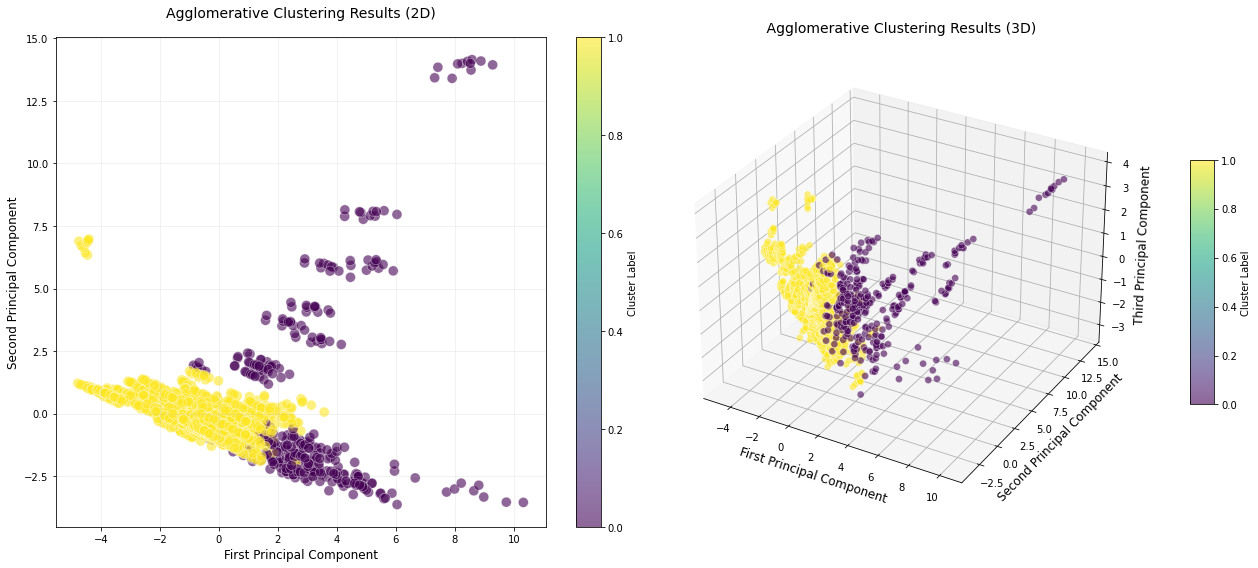

In [28]:

# יצירת גרף עם שני תת-גרפים
fig = plt.figure(figsize=(18, 8))

# גרף דו-ממדי
ax1 = fig.add_subplot(121)
scatter2d = ax1.scatter(
    X_pca_2c[:, 0], X_pca_2c[:, 1],
    c=clusters_agg,
    cmap='viridis',
    alpha=0.6,
    s=100,  # גודל נקודות
    edgecolors='white',  # שולי נקודות בלבן
    linewidth=0.5
)
ax1.set_title('Agglomerative Clustering Results (2D)', pad=20, size=14)
ax1.set_xlabel('First Principal Component', size=12)
ax1.set_ylabel('Second Principal Component', size=12)
ax1.grid(True, alpha=0.2)
fig.colorbar(scatter2d, ax=ax1, label='Cluster Label')

# גרף תלת-ממדי
ax2 = fig.add_subplot(122, projection='3d')
scatter3d = ax2.scatter(
    X_pca_3c[:, 0], X_pca_3c[:, 1], X_pca_3c[:, 2],
    c=clusters_agg,
    cmap='viridis',
    alpha=0.6,
    s=50,  # גודל נקודות
    edgecolors='white',  # שולי נקודות בלבן
    linewidth=0.5
)
ax2.set_title(' Agglomerative Clustering Results (3D)', pad=20, size=14)
ax2.set_xlabel('First Principal Component', size=12)
ax2.set_ylabel('Second Principal Component', size=12)
ax2.set_zlabel('Third Principal Component', size=12)
fig.colorbar(scatter3d, ax=ax2, shrink=0.5, aspect=10, pad=0.1, label='Cluster Label')

# עיצוב וסידור
plt.tight_layout()
plt.show()

### Interpretation of the Clustering Models

- **DBSCAN**: The model struggled to classify the data into meaningful clusters but successfully identified outliers in the dataset.
- **Agglomerative Clustering & K-Means**: These models produced clusters that were slightly "stretched" or less distinct due to their sensitivity to outliers.

Based on these observations, we decided to remove the outliers detected by DBSCAN and reapply the Agglomerative Clustering and K-Means models without the influence of the outliers.


In [29]:
X['clusters'] = clusters_db
# הפרדת רעש (Outliers) מנקודות באשכולות
X_outliers = X[clusters_db == -1]
X_inliers = X[clusters_db != -1]
X_inliers = X_inliers.drop(columns=['clusters'])

## **Cumulative Explained Variance using PCA (without outliers)**

In this step, we use Principal Component Analysis (PCA) to compute the cumulative explained variance. This helps to identify the number of components required to retain most of the variability in the dataset. The plot below visualizes the cumulative variance explained as a function of the number of components:

- **X-axis**: Number of components.
- **Y-axis**: Cumulative explained variance.

This analysis is crucial for dimensionality reduction and determining the optimal number of components to retain.

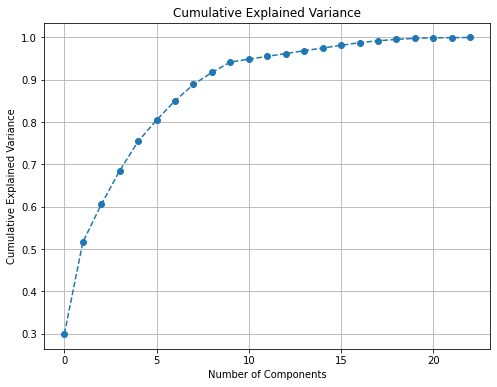

In [30]:
# שלב 3: חישוב שונות מוסברת
pca_inliers = PCA()
pca_inliers.fit(X_inliers)



cumulative_variance_ratio_inliers = np.cumsum(pca_inliers.explained_variance_ratio_)

# שלב 4: הדמיית השונות המצטברת
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [31]:
cumulative_variance_ratio_inliers

array([0.34315481, 0.51518776, 0.61609478, 0.71141217, 0.78823668,
       0.8475728 , 0.90099143, 0.94396027, 0.97836427, 0.99523948,
       0.99861904, 0.999487  , 1.        ])

In [32]:
pca_inliers.explained_variance_ratio_

array([0.34315481, 0.17203296, 0.10090702, 0.09531739, 0.07682451,
       0.05933612, 0.05341862, 0.04296885, 0.034404  , 0.01687521,
       0.00337957, 0.00086796, 0.000513  ])

### **Interpretation of Cumulative Explained Variance**

The cumulative explained variance array represents the proportion of variance explained by the principal components. Based on the results, we observe that **7 components** capture approximately **85% of the total variance**, and we have decided to retain these components for dimensionality reduction. 

By reducing the dimensionality, we also aim to eliminate some of the noise in the data, improving the clarity and efficiency of subsequent analyses.

In [33]:
pca1_inliers = PCA(n_components=7)
X_pca_inliers = pca1_inliers.fit_transform(X_inliers)

## **Elbow Method for Optimal Clusters**

This step uses the Elbow Method to identify the optimal number of clusters (`k`) for the K-Means algorithm. By plotting the **inertia** (sum of squared distances) against `k`, the **elbow point** indicates the optimal `k`, balancing cluster compactness and model simplicity.

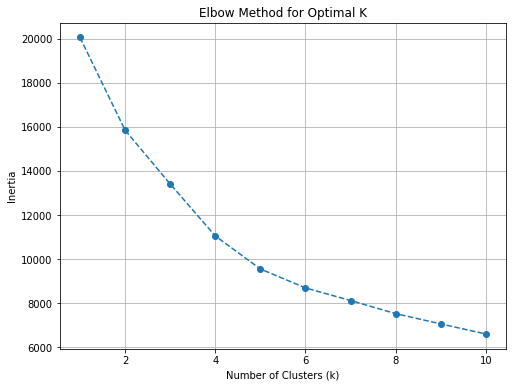

In [34]:
inertia_values = []
k_values = range(1, 11)
# חישוב Inertia עבור כל K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca_inliers)  # ודא ש-X מוכן ומנורמל
    inertia_values.append(kmeans.inertia_)

# יצירת גרף Elbow
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_values, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

* The Elbow Point still on K = 4 without the outliers.

### **PCA: 2D and 3D Transformations (inliers)**

In [35]:
pca2c_inliers = PCA(n_components=2)
X_pca_2c_inliers = pca2c_inliers.fit_transform(X_inliers)

pca3c_inliers = PCA(n_components=3)
X_pca_3c_inliers = pca3c_inliers.fit_transform(X_inliers)

## **K-Means Clustering Visualization (2D and 3D)**

Here, we visualize the clustering results from the K-Means algorithm with **k=4 clusters**. 

- **Left plot**: A 2D scatter plot showing the clusters using the first two PCA.
- **Right plot**: A 3D scatter plot illustrating the clusters using the first three PCA. 

These visualizations provide insights into the cluster separation and structure.

In [36]:
kmeans_inliers = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters_km_inliers = kmeans_inliers.fit_predict(X_pca_inliers)

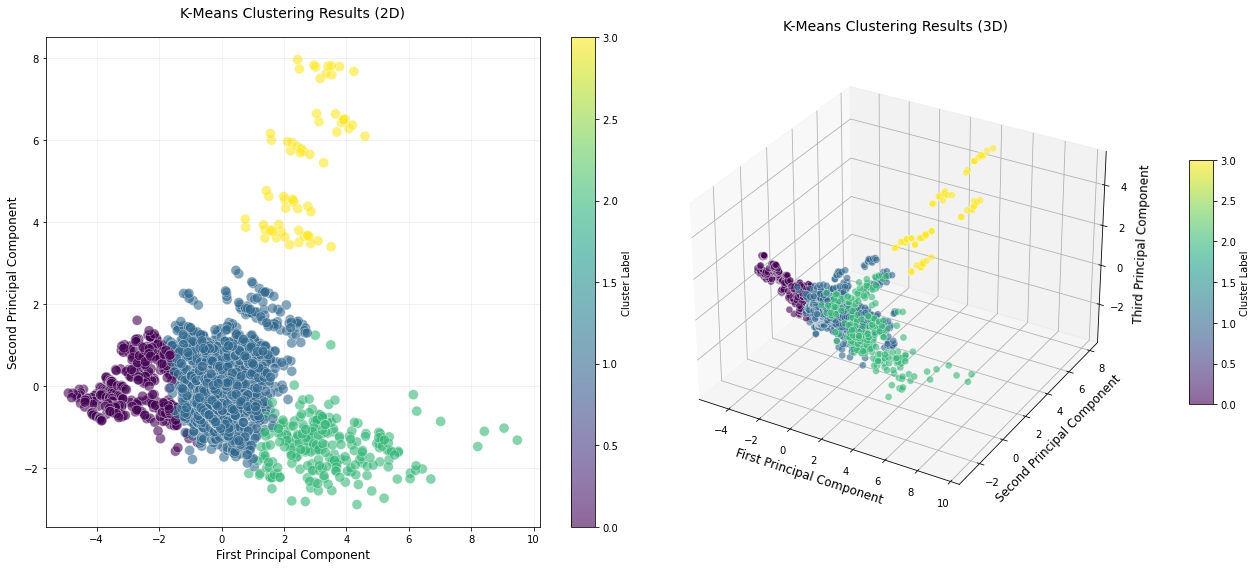

In [37]:

# יצירת גרף עם שני תת-גרפים
fig = plt.figure(figsize=(18, 8))

# גרף דו-ממדי
ax1 = fig.add_subplot(121)
scatter2d = ax1.scatter(
    X_pca_2c_inliers[:, 0], X_pca_2c_inliers[:, 1],
    c=clusters_km_inliers,
    cmap='viridis',
    alpha=0.6,
    s=100,  # גודל נקודות
    edgecolors='white',  # שולי נקודות בלבן
    linewidth=0.5
)
ax1.set_title('K-Means Clustering Results (2D)', pad=20, size=14)
ax1.set_xlabel('First Principal Component', size=12)
ax1.set_ylabel('Second Principal Component', size=12)
ax1.grid(True, alpha=0.2)
fig.colorbar(scatter2d, ax=ax1, label='Cluster Label')

# גרף תלת-ממדי
ax2 = fig.add_subplot(122, projection='3d')
scatter3d = ax2.scatter(
    X_pca_3c_inliers[:, 0], X_pca_3c_inliers[:, 1], X_pca_3c_inliers[:, 2],
    c=clusters_km_inliers,
    cmap='viridis',
    alpha=0.6,
    s=50,  # גודל נקודות
    edgecolors='white',  # שולי נקודות בלבן
    linewidth=0.5
)
ax2.set_title('K-Means Clustering Results (3D)', pad=20, size=14)
ax2.set_xlabel('First Principal Component', size=12)
ax2.set_ylabel('Second Principal Component', size=12)
ax2.set_zlabel('Third Principal Component', size=12)
fig.colorbar(scatter3d, ax=ax2, shrink=0.5, aspect=10, pad=0.1, label='Cluster Label')

# עיצוב וסידור
plt.tight_layout()
plt.show()


## **Agglomerative Clustering Parameter Tuning**

Here, we tune the `n_clusters` parameter for Agglomerative Clustering by testing values from 2 to 6. The best value is chosen based on the highest Silhouette Score.

In [38]:
n_clusters_values = range(2,7)
best_score = -1
best_params = {}

# חיפוש פרמטרים
for n_clusters in n_clusters_values:
        agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
        clusters = agg_clustering.fit_predict(X_pca_inliers)
        score = silhouette_score(X_pca_inliers, clusters)
        
        if score > best_score:
            best_score = score
            best_params = {'n_clusters': n_clusters}

print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

Best Silhouette Score: 0.3850
Best Parameters: {'n_clusters': 3}


* The `n_clusters` changed to **3** from 2 without the outliers.

## ** Clustering Visualization (2D and 3D)**

Here, we visualize the clustering results from the Agglomerative algorithm with `n_clusters` = 3. 

- **Left plot**: A 2D scatter plot showing the clusters using the first two PCA.
- **Right plot**: A 3D scatter plot illustrating the clusters using the first three PCA. 

These visualizations provide insights into the cluster separation and structure.

In [39]:
agg_inliers = AgglomerativeClustering(n_clusters=3)
clusters_agg_inliers = agg_inliers.fit_predict(X_pca_inliers)

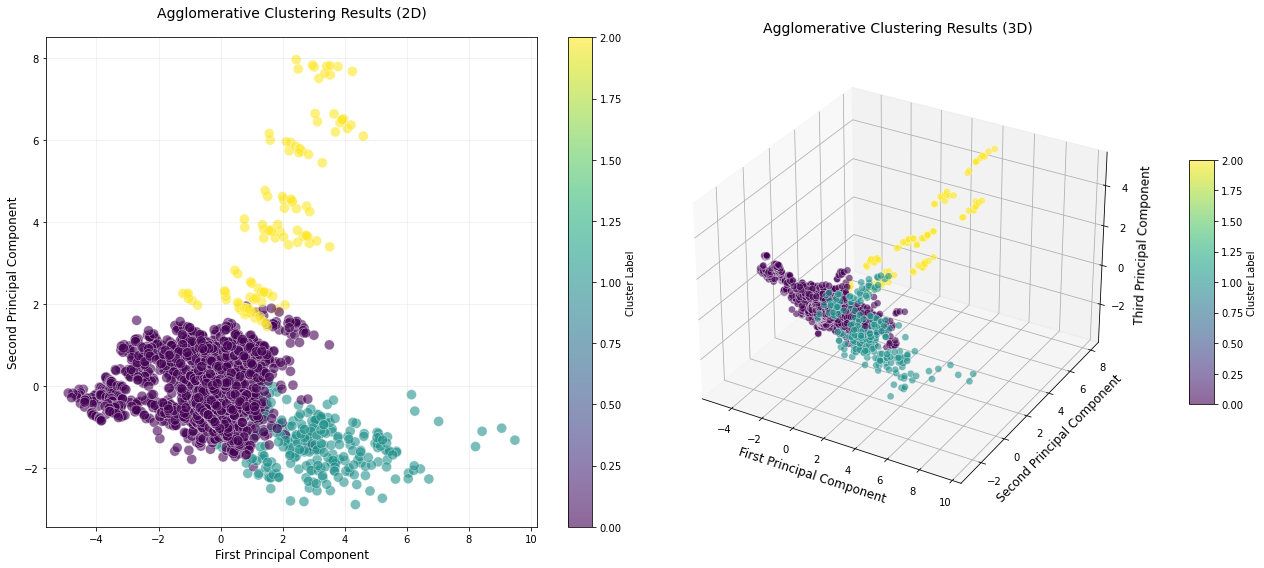

In [40]:
# יצירת גרף עם שני תת-גרפים
fig = plt.figure(figsize=(18, 8))

# גרף דו-ממדי
ax1 = fig.add_subplot(121)
scatter2d = ax1.scatter(
    X_pca_2c_inliers[:, 0], X_pca_2c_inliers[:, 1],
    c=clusters_agg_inliers,
    cmap='viridis',
    alpha=0.6,
    s=100,  # גודל נקודות
    edgecolors='white',  # שולי נקודות בלבן
    linewidth=0.5
)
ax1.set_title('Agglomerative Clustering Results (2D)', pad=20, size=14)
ax1.set_xlabel('First Principal Component', size=12)
ax1.set_ylabel('Second Principal Component', size=12)
ax1.grid(True, alpha=0.2)
fig.colorbar(scatter2d, ax=ax1, label='Cluster Label')

# גרף תלת-ממדי
ax2 = fig.add_subplot(122, projection='3d')
scatter3d = ax2.scatter(
    X_pca_3c_inliers[:, 0], X_pca_3c_inliers[:, 1], X_pca_3c_inliers[:, 2],
    c=clusters_agg_inliers,
    cmap='viridis',
    alpha=0.6,
    s=50,  # גודל נקודות
    edgecolors='white',  # שולי נקודות בלבן
    linewidth=0.5
)
ax2.set_title('Agglomerative Clustering Results (3D)', pad=20, size=14)
ax2.set_xlabel('First Principal Component', size=12)
ax2.set_ylabel('Second Principal Component', size=12)
ax2.set_zlabel('Third Principal Component', size=12)
fig.colorbar(scatter3d, ax=ax2, shrink=0.5, aspect=10, pad=0.1, label='Cluster Label')

# עיצוב וסידור
plt.tight_layout()
plt.show()


### Interpretation of Clustering Algorithms Without Outliers

After removing the outliers detected by DBSCAN, we re-evaluated the data using **Agglomerative Clustering** and **K-Means**:

- Both algorithms produced relatively similar clusters in terms of data distribution. 
- However, **K-Means** created 4 clusters, while **Agglomerative Clustering** formed 3 clusters.

To ensure robust classification, we decided to retain only the data points where both algorithms agreed on their clustering. This approach provides a consistent and reliable classification of the data.


In [41]:
X_inliers['clusters_km'] = clusters_km_inliers
X_inliers['clusters_agg'] = clusters_agg_inliers

### Aligning Cluster Labels for Consistency

In this step, we mapped the cluster labels from the **K-Means** algorithm to match the corresponding labels from **Agglomerative Clustering**. The `mapping` dictionary was used to reassign the cluster labels for consistency across the clustering results.


In [42]:
mapping = {0:3, 1:0, 2:1 ,3:2}

X_inliers['clusters_km'] = X_inliers['clusters_km'].replace(mapping)
X_inliers = X_inliers[X_inliers['clusters_agg'] == X_inliers['clusters_km']]
X_inliers = X_inliers[X_inliers['clusters_agg'] == X_inliers['clusters_km']]
X_inliers['clusters'] = X_inliers['clusters_km']
X_inliers = X_inliers.drop(columns=['clusters_km','clusters_agg'])

In [44]:
X_inliers['clusters'] = X_inliers['clusters_km']

In [45]:
X_inliers = X_inliers.drop(columns=['clusters_km','clusters_agg'])

### Ploting the final clustering on 2D PCA graph

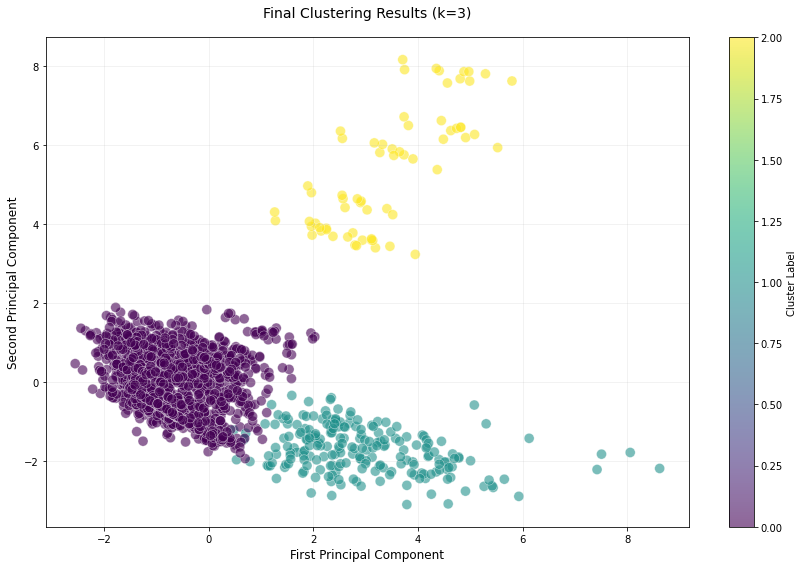

In [46]:
pca2c_inliers_match = PCA(n_components=2)
X_pca_2c_inliers_match = pca2c_inliers_match.fit_transform(X_inliers)

# Create visualization with improved styling
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    X_pca_2c_inliers_match[:, 0], X_pca_2c_inliers_match[:, 1],
    c=X_inliers.clusters,
    cmap='viridis',
    alpha=0.6,
    s=100,  # Increased point size
    edgecolors='white',  # White edges for better contrast
    linewidth=0.5,
)


# Improve plot styling
plt.colorbar(scatter, label='Cluster Label')
plt.title('Final Clustering Results (k=3)', pad=20, size=14)
plt.xlabel('First Principal Component', size=12)
plt.ylabel('Second Principal Component', size=12)
plt.grid(True, alpha=0.2)

# Add tight layout to prevent label cutoff
plt.tight_layout()
plt.show()

### Restoring Original Numerical Feature Values

In this step, we restored the original numerical feature values for the **inliers** dataset. After the clustering process, the numerical features were scaled during preprocessing.


In [47]:
# שמירת העמודות המספריות מתוך X_inliers
num_col_names = list(numerical_features)
X_inliers_num = X_inliers[num_col_names]

# שחזור הערכים המקוריים
X_inliers_original_num = preprocessor.named_transformers_['num'].inverse_transform(X_inliers_num)

# עדכון העמודות המספריות ב-X_inliers עם הערכים המקוריים
X_inliers[num_col_names] = X_inliers_original_num

### Group the average by the cluster labels

In [53]:
X_analysis = X_inliers.groupby('clusters').mean()
X_analysis

,TOTAL_ASSETS,AVG_ANNUAL_MANAGEMENT_FEE,AVG_DEPOSIT_FEE,MONTHLY_YIELD,YEAR_TO_DATE_YIELD,YIELD_TRAILING_3_YRS,YIELD_TRAILING_5_YRS,STANDARD_DEVIATION,ALPHA,SHARPE_RATIO,LIQUID_ASSETS_PERCENT,STOCK_MARKET_EXPOSURE,FOREIGN_CURRENCY_EXPOSURE
clusters,,,,,,,,,,,,,
0,983.467069,0.720002,1.810387,0.913706,5.114954,10.454765,28.308760,6.980028,0.670070,0.490797,85.982472,376.234161,271.283107
1,1105.646743,0.762163,1.488028,2.326055,12.871284,25.735104,55.500860,12.489530,1.156697,0.668360,94.947248,1083.939404,675.084072
2,29714.469545,0.763333,2.235000,1.024091,5.876212,14.238939,37.011818,7.284545,1.600000,0.664697,71.063636,13359.720606,7531.771061


In [51]:
X_inliers.describe()

,TOTAL_ASSETS,AVG_ANNUAL_MANAGEMENT_FEE,AVG_DEPOSIT_FEE,MONTHLY_YIELD,YEAR_TO_DATE_YIELD,YIELD_TRAILING_3_YRS,YIELD_TRAILING_5_YRS,STANDARD_DEVIATION,ALPHA,SHARPE_RATIO,LIQUID_ASSETS_PERCENT,STOCK_MARKET_EXPOSURE,FOREIGN_CURRENCY_EXPOSURE,clusters
count,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000
mean,2147.438820,0.727296,1.784812,1.104492,6.168902,12.622361,32.244764,7.719235,0.771438,0.521176,86.569444,988.334553,614.637111,0.211864
std,6062.078266,0.194114,1.075360,1.531706,4.808745,7.661912,12.264092,2.313099,0.844952,0.140980,10.603109,2754.713094,1565.719233,0.497022
min,0.000000,0.000000,0.000000,-5.770000,-3.550000,-4.450000,10.060000,3.980000,-1.680000,0.120000,56.900000,0.000000,0.000000,0.000000
25%,66.167500,0.600000,1.080000,0.300000,2.970000,10.230000,28.230000,7.000000,0.480000,0.470000,76.700000,16.725000,13.922500,0.000000
50%,345.595000,0.747683,2.110000,1.070000,4.785000,10.230000,28.230000,7.000000,0.480000,0.470000,88.000000,182.035000,116.580000,0.000000
75%,1840.237500,0.830000,2.230000,1.860000,8.662500,13.522500,33.177500,7.660000,0.960000,0.570000,97.900000,720.627500,518.390000,0.000000
max,46406.280000,2.000000,4.990000,8.400000,28.120000,57.220000,110.200000,15.970000,5.400000,1.320000,100.000000,23142.120000,11764.600000,2.000000


## **Feature Distributions Across Clusters**

We use **Box Plots** to visualize how each feature is distributed across the identified clusters. This helps in understanding the key differences between clusters and their defining characteristics. 


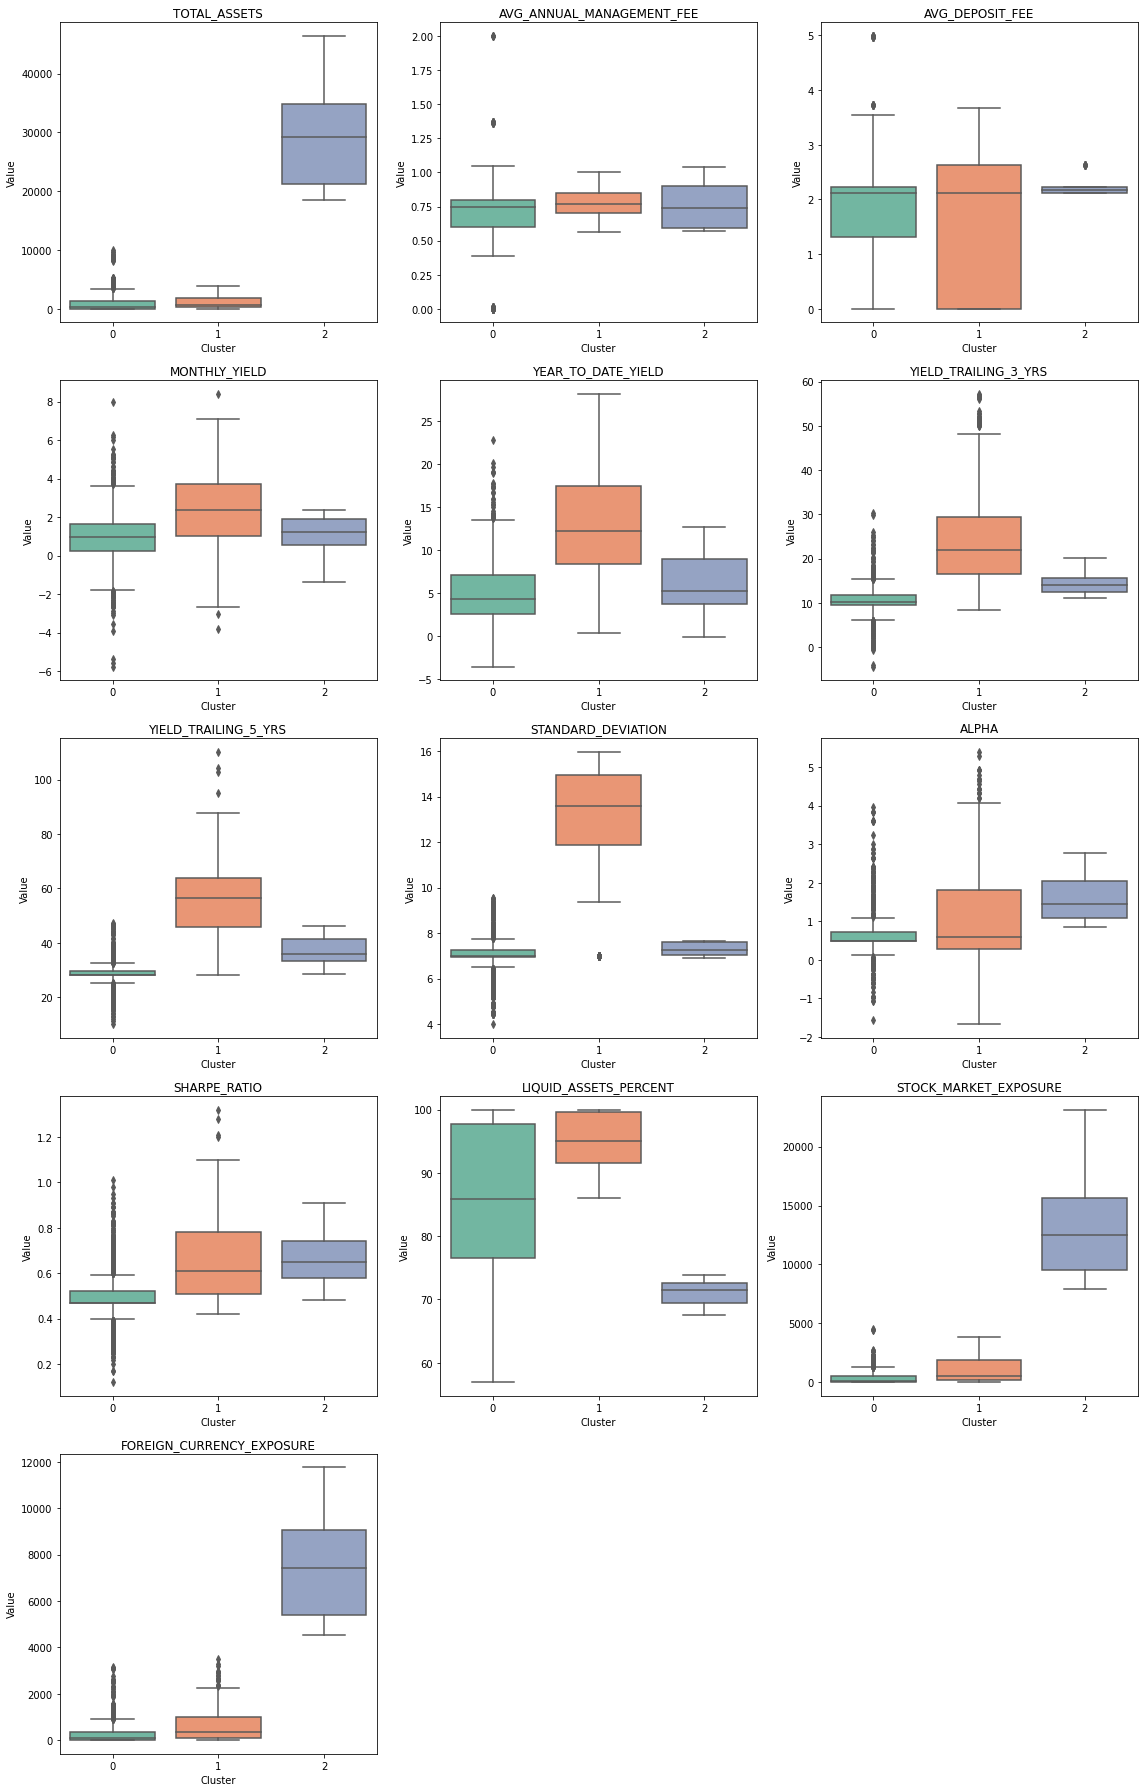

In [55]:
# עמודת הקלאסטרים
cluster_column = 'clusters'

# הגדרות
n_cols = 3  # מספר תרשימים בכל שורה
n_rows = math.ceil((len(X_inliers.columns) - 1) / n_cols)  # מספר שורות (ללא עמודת הקלאסטרים)

# יצירת גריד של תרשימים
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

# יצירת תרשימי Box Plot
for i, col in enumerate(X_inliers.columns):
    if col != cluster_column:
        sns.boxplot(data=X_inliers, x=cluster_column, y=col, palette='Set2', ax=axes[i])
        axes[i].set_title(f"{col}")
        axes[i].set_xlabel("Cluster")
        axes[i].set_ylabel("Value")

# הסרת גרפים ריקים אם יש
for j in range(i , len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



### Cluster Observations

- **Cluster 2**: Clearly exhibits significantly high values for `TOTAL_ASSETS`, `STOCK_MARKET_EXPOSURE`, and `FOREIGN_CURRENCY_EXPOSURE` compared to the other clusters. The high total assets suggest that this group holds substantial resources, enabling them to diversify heavily into foreign investments and stock market exposure.

- **Cluster 1**: Clearly has the largest `Standard Deviation`, indicating higher variability in returns. This suggests that Cluster 1 takes on more investment risks, leading to potentially higher gains or losses. Additionally, the yield over the years (`YIELD_TRAILING_3_YRS` and `YIELD_TRAILING_5_YRS`) is relatively higher compared to other clusters, reinforcing the idea of a high-risk, high-reward strategy.

- **Cluster 0**: This group performs relatively poorly when compared to the other clusters. This likely represents a conservative investment strategy or underperforming funds with lower asset allocation and yield.
